

### Setup
- sam_dataset
    - baars
        - baars data
    - snoek
        - snoek data
        
- Needs to split this data into train + test. First get the model working

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', co

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Train Test Split Directories

In [ ]:
#TODO: add custom loader for multiple model classifier

In [122]:
TRAIN_RATIO = 0.8

ROOT = '.'
data_dir = os.path.join(ROOT, 'fitted_images')
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

classes = classes[:10]
print(classes)

for c in classes:
    class_dir = os.path.join(images_dir, c)
    
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        if 'ipynb_checkpoints' not in image_src:
            shutil.copyfile(image_src, image_dst)
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        if 'ipynb_checkpoints' not in image_src:
            shutil.copyfile(image_src, image_dst)

['marmergrondel', 'fint', 'siberische_steur', 'karper', 'blauwneus', 'dunlipharder', 'tiendoornige_stekelbaars', 'snoekbaars', 'riviergrondel', 'gestippelde_alver']


In [94]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.0696, 0.0651, 0.0591])
Calculated stds: tensor([0.1770, 0.1674, 0.1550])


In [95]:
pretrained_size = 224
pretrained_means = [0.0763, 0.0697, 0.0617]
pretrained_stds= [0.1850, 0.1717, 0.1560]

train_transforms = transforms.Compose([
#                            transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomVerticalFlip(0.5),
#                            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
#                            transforms.Resize(pretrained_size),
#                            transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [96]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [97]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [98]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [99]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 349
Number of validation examples: 39
Number of testing examples: 101


In [100]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

### Test Plot

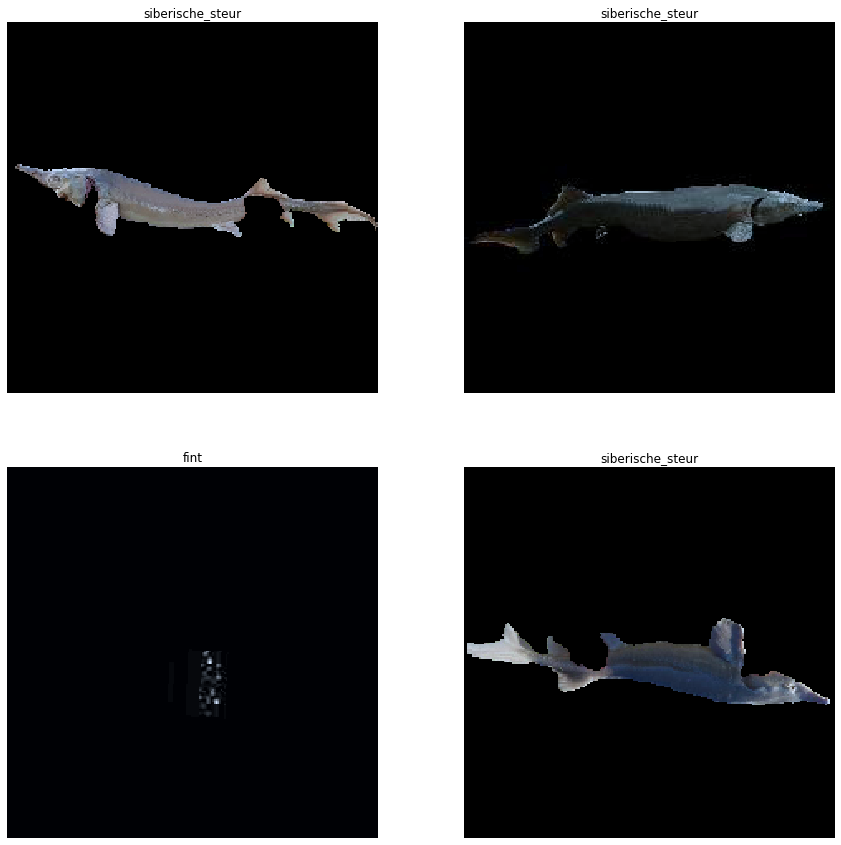

In [101]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image   


def plot_images(images, labels, classes, normalize = True):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]
        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')
        
N_IMAGES = 6

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

## Defining the Model
### Defining the ResNet50 model

In [102]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [103]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [104]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])


In [105]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [106]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

### Downloading Pretrained model weights

In [107]:
OUTPUT_DIM = len(test_data.classes)

pretrained_model = models.resnet50(pretrained = True)

IN_FEATURES = pretrained_model.fc.in_features 

model = ResNet(resnet50_config, OUTPUT_DIM)

In [108]:
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

In [109]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [110]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,528,522 trainable parameters


In [111]:
device = 'cuda'
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

### Defining Learning Rate

In [112]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [113]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

Stopping early, the loss has diverged


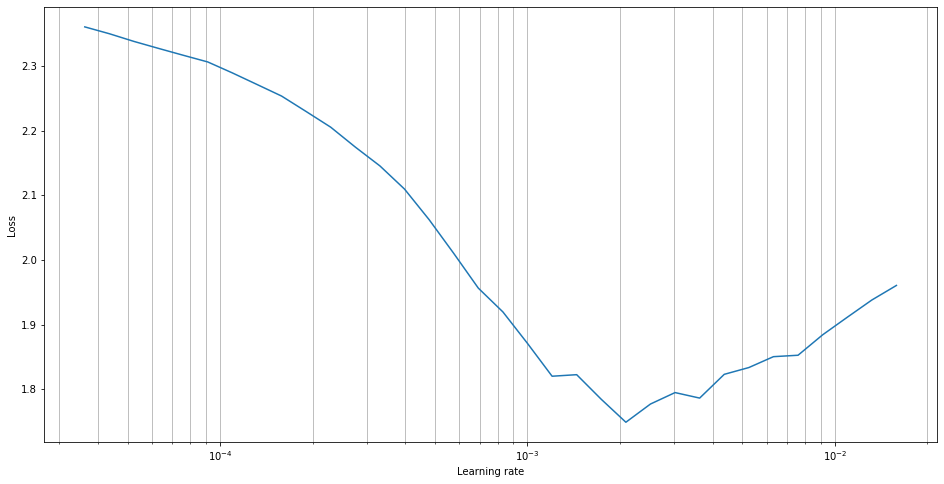

In [114]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [115]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

### Setup an LR scheduler

In [116]:
EPOCHS = 50
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [117]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

## Training and Evaluation

In [118]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [119]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)
            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [120]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [121]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 2.281 | Train Acc @1:  11.79% | Train Acc @5:  23.31%
	Valid Loss: 2.249 | Valid Acc @1:  15.62% | Valid Acc @5:  23.44%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 2.044 | Train Acc @1:  44.22% | Train Acc @5:  60.79%
	Valid Loss: 1.994 | Valid Acc @1:  54.24% | Valid Acc @5:  64.51%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 1.709 | Train Acc @1:  61.98% | Train Acc @5:  77.95%
	Valid Loss: 1.650 | Valid Acc @1:  54.24% | Valid Acc @5:  64.51%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 1.254 | Train Acc @1:  68.17% | Train Acc @5:  82.18%
	Valid Loss: 1.107 | Valid Acc @1:  70.09% | Valid Acc @5:  81.92%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.816 | Train Acc @1:  79.37% | Train Acc @5:  86.53%
	Valid Loss: 0.969 | Valid Acc @1:  66.07% | Valid Acc @5:  88.17%
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.495 | Train Acc @1:  87.01% | Train Acc @5:  93.35%
	Valid Loss: 0.959 | Valid Acc @1:  71.65% | Valid Acc @5:  81.92%
Epoch: 07 | Epoc

### Model Examination

In [53]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [55]:
images, labels, probs = get_predictions(model, test_iterator)

'baars'

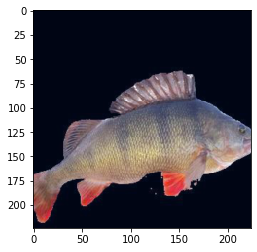

In [64]:
images[0].shape, labels[0]
image = normalize_image(images[0])
plt.imshow(  image.permute(1, 2, 0)  )
test_data.classes[labels[0]]

In [ ]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)